In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:

# Define the test data directory
test_data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Testing"

# Define the transforms for the first five models (150x150)
transform_150 = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Define the transforms for the sixth model (224x224)
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the test dataset for the first five models
test_dataset_150 = ImageFolder(test_data_dir, transform=transform_150)
test_dl_150 = DataLoader(test_dataset_150, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Load the test dataset for the sixth model
test_dataset_224 = ImageFolder(test_data_dir, transform=transform_224)
test_dl_224 = DataLoader(test_dataset_224, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:

# Load the trained models (assuming the models are saved as 'model1.pkl', 'model2.pkl', etc.)
models_150 = []
for i in range(1, 6):
    with open(f'/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/computer_vision/cnn+vit/model_fold_{i}.pkl', 'rb') as f:
        model = pickle.load(f)
        model.to(device)
        model.eval()  # Set the model to evaluation mode
        models_150.append(model)

# Load the sixth model
with open('/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/computer_vision/cnn+vit/modelb16.pkl', 'rb') as f:
    model_224 = pickle.load(f)
    model_224.to(device)
    model_224.eval()  # Set the model to evaluation mode

# Function to evaluate the models and get predictions
def evaluate_models(models_150, model_224, dataloader_150, dataloader_224, device):
    true_labels = []
    all_preds = []
    i = 1
    with torch.no_grad():  # Disable gradient calculation
        for (inputs_150, labels_150), (inputs_224, labels_224) in zip(dataloader_150, dataloader_224):
            inputs_150 = inputs_150.to(device)
            inputs_224 = inputs_224.to(device)
            labels_150 = labels_150.to(device)
            labels_224 = labels_224.to(device)

            # Ensure the labels are the same for both dataloaders
            assert torch.equal(labels_150, labels_224)

            fold_preds = []
            for model in models_150:
                outputs = model(inputs_150)                
                preds = torch.softmax(outputs, dim=1)  # Get probabilities
                # print("pred",preds)
                fold_preds.append(preds.cpu().numpy())
            
            outputs_224 = model_224(inputs_224)
            preds_224 = torch.softmax(outputs_224, dim=1)  # Get probabilities
            # print("224", preds_224)
            fold_preds.append(preds_224.cpu().numpy())
            # print(fold_preds)
            avg_preds = np.mean(fold_preds, axis=0)
            final_preds = np.argmax(avg_preds, axis=1)

            true_labels.extend(labels_150.cpu().numpy())
            all_preds.extend(final_preds)

    return np.array(true_labels), np.array(all_preds)

# Get true and predicted labels
true_labels, pred_labels = evaluate_models(models_150, model_224, test_dl_150, test_dl_224, device)



              precision    recall  f1-score   support

      glioma       0.96      0.97      0.97       300
  meningioma       0.97      0.93      0.95       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



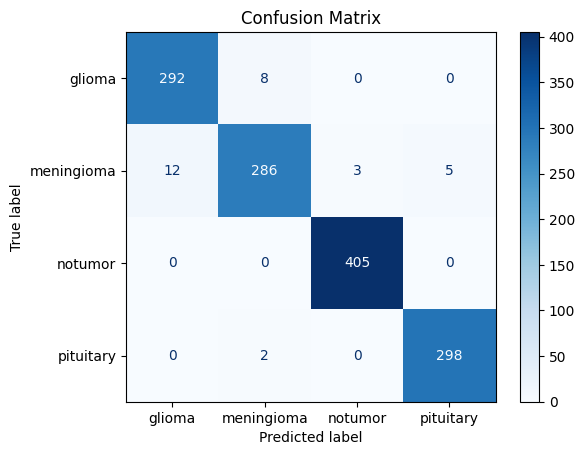

In [9]:

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=test_dataset_150.classes))

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset_150.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()